Load required packages

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import configs as c
import common_functions as func
import markov as m
import calibration_plots as p

In [6]:
def plot_vs_seer(curr_log, seer_inc, save_imgs=False, outpath=None, timestamp=None):
    """Plot model incidence by stage vs. SEER calibration incidence

    Args:
        curr_log (tuple): output log from run_markov. tuple containing inc_adj, ...
        seer_inc (df): item of comparison
    """
    inc_adj, _, _, _ = curr_log
    x_values = np.linspace(20, 99, 80)

    plt.plot(
        seer_inc["Age"],
        seer_inc["Local Rate"],
        label="Local (SEER)",
        color="b",
        linestyle="dotted",
    )
    plt.plot(
        seer_inc["Age"],
        seer_inc["Regional Rate"],
        label="Regional (SEER)",
        color="r",
        linestyle="dotted",
    )
    plt.plot(
        seer_inc["Age"],
        seer_inc["Distant Rate"],
        label="Distant (SEER)",
        color="g",
        linestyle="dotted",
    )
    plt.plot(x_values, inc_adj[6, :], label="Local (Model)", color="b")
    plt.plot(x_values, inc_adj[7, :], label="Regional (Model)", color="r")
    plt.plot(x_values, inc_adj[8, :], label="Distant (Model)", color="g")
    plt.legend()
    plt.title("Incidence of Local, Regional, and Distant States")
    plt.xlabel("Time Point / Age Group")
    plt.ylabel("incidence")
    if save_imgs:
        plt.savefig(f"{outpath}/{timestamp}_inc_stage.png")  # Save figure
        plt.close()
    else:
        plt.show()

    plt.plot(
        seer_inc["Age"],
        seer_inc["Local Rate"].cumsum(),
        label="Local (SEER)",
        color="b",
        linestyle="dotted",
    )
    plt.plot(
        seer_inc["Age"],
        seer_inc["Regional Rate"].cumsum(),
        label="Regional (SEER)",
        color="r",
        linestyle="dotted",
    )
    plt.plot(
        seer_inc["Age"],
        seer_inc["Distant Rate"].cumsum(),
        label="Distant (SEER)",
        color="g",
        linestyle="dotted",
    )
    plt.plot(x_values, inc_adj[6, :].cumsum(), label="Local (Model)", color="b")
    plt.plot(x_values, inc_adj[7, :].cumsum(), label="Regional (Model)", color="r")
    plt.plot(x_values, inc_adj[8, :].cumsum(), label="Distant (Model)", color="g")
    plt.legend()
    plt.title("Cumulative Incidence of Local, Regional, and Distant States")
    plt.xlabel("Time Point / Age Group")
    plt.ylabel("incidence")
    if save_imgs:
        plt.savefig(f"{outpath}/{timestamp}_inc_stage_cum.png")  # Save figure
        plt.close()
    else:
        plt.show()

In [42]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]):  # Loop over each age layer
        layer = matrix[age_layer]
        # Calculate the sum of non-diagonal elements for each row
        sum_of_columns = np.sum(layer, axis=1) - np.diag(layer)
        # Set the diagonal elements
        np.fill_diagonal(layer, 1 - sum_of_columns)
    return matrix

Load tmat 20240923_1243 and get log

In [7]:
tmat = np.load("../out/US/interp/tmats/20240923_1243_tmat.npy")
log = m.run_markov_new(tmat)

# Compare plots

## Original

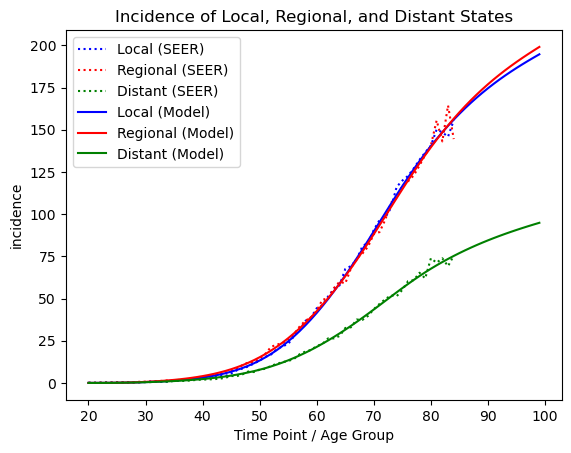

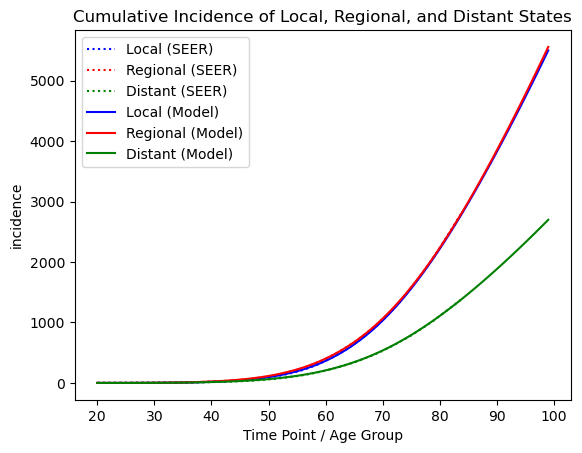

In [13]:
plot_vs_seer(log, c.seer_inc)

## Lower uLoc_uReg

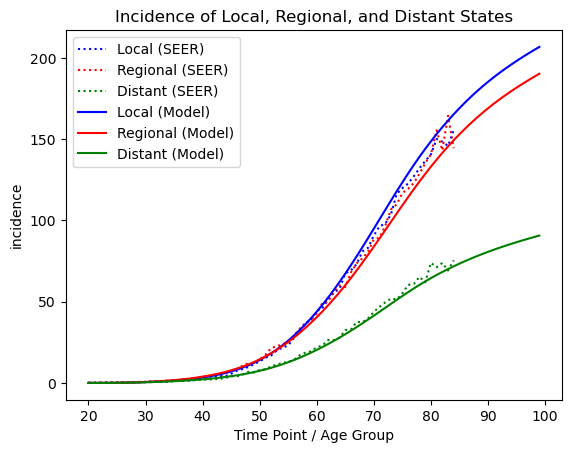

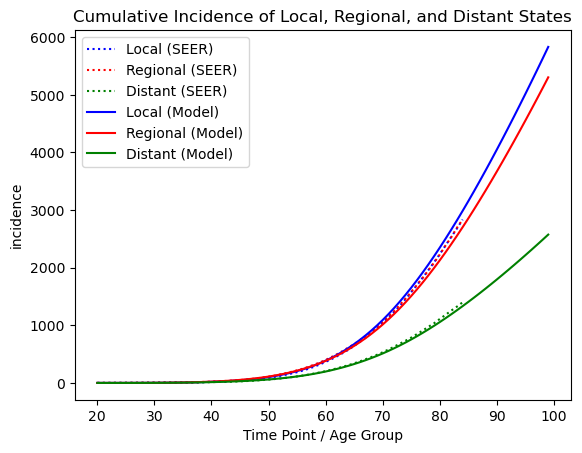

In [44]:
tmat2 = np.copy(tmat)
tmat2[:,3,4] *= 0.9  # Slow down local to regional
tmat2 = row_normalize(tmat2)
log2 = m.run_markov_new(tmat2)
plot_vs_seer(log2, c.seer_inc)

## Raise HRpolyp_uLoc

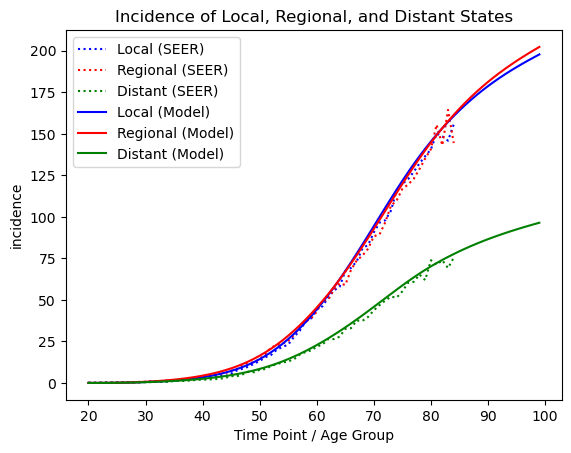

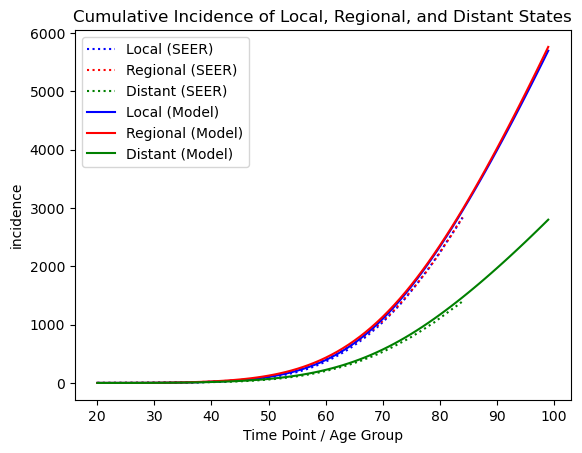

In [45]:
tmat3 = np.copy(tmat)
tmat3[:,2,3] *= 1.1  # Speed up HR polyp to local
tmat3 = row_normalize(tmat3)
log3 = m.run_markov_new(tmat3)
plot_vs_seer(log3, c.seer_inc)

## Lower uLoc_uReg and raise HRpolyp_uLoc

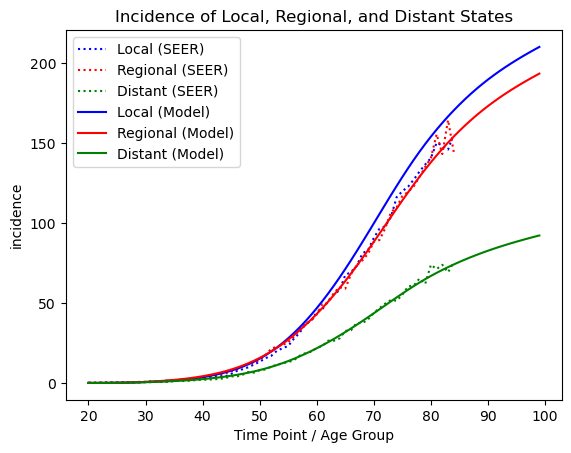

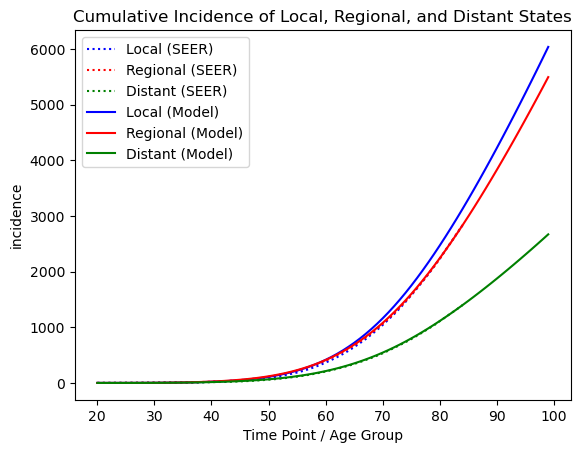

In [46]:
tmat4 = np.copy(tmat2)
tmat4[:,2,3] *= 1.1
tmat4 = row_normalize(tmat4)
log4 = m.run_markov_new(tmat4)
plot_vs_seer(log4, c.seer_inc)

## Cap uLoc_uReg at 0.4

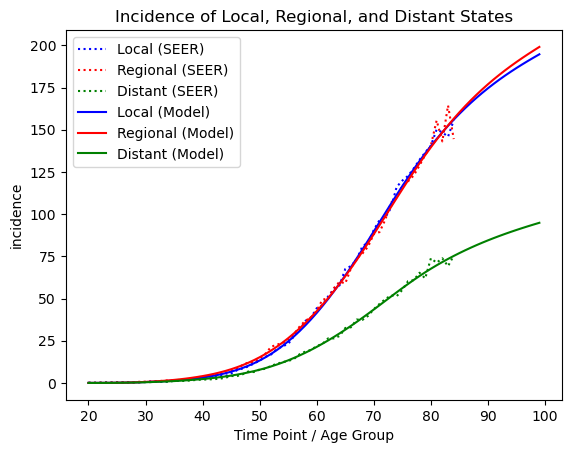

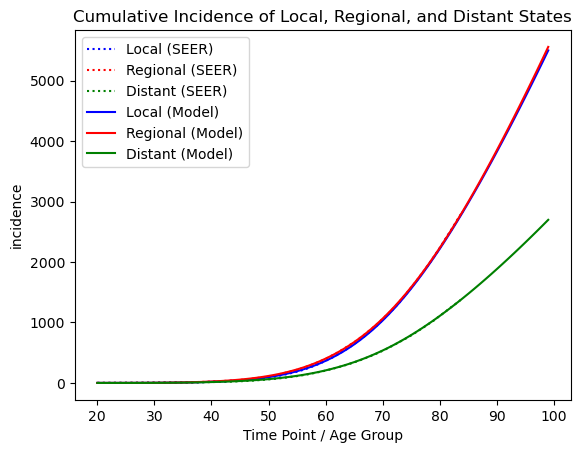

In [47]:
tmat5 = np.copy(tmat)
tmat5[:,3,4] = np.minimum(tmat5[:,3,4],func.probtoprob(0.4))  # Cap loc to reg at 0.4
tmat5 = row_normalize(tmat5)
log5 = m.run_markov_new(tmat5)
plot_vs_seer(log5, c.seer_inc)

## Set reg_distant as constant

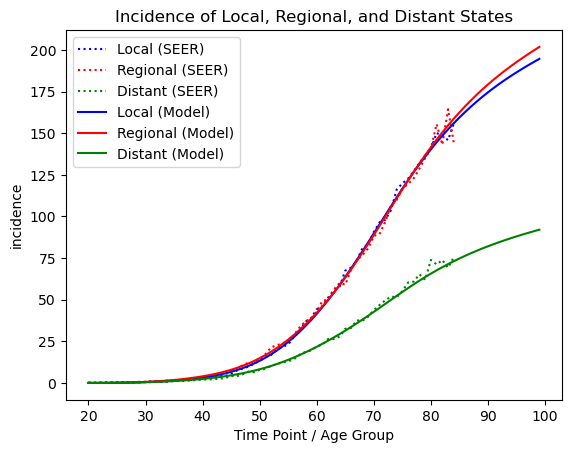

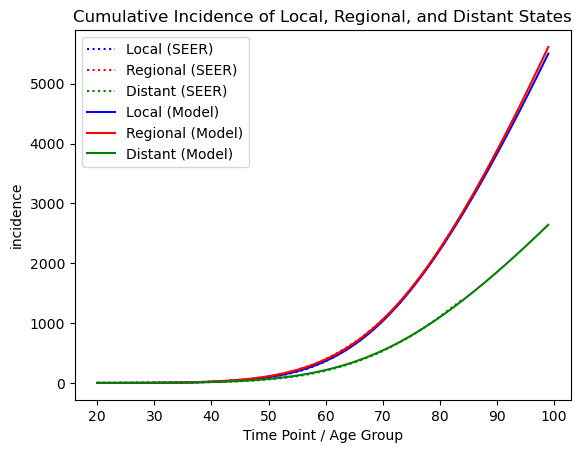

In [48]:
tmat5[:,4,5] = np.mean(tmat5[:,4,5])
tmat5 = row_normalize(tmat5)
log5b = m.run_markov_new(tmat5)
plot_vs_seer(log5b,c.seer_inc)

In [41]:
print(func.probtoprob(min(tmat[:,0,1]),12,1))
print(func.probtoprob(max(tmat[:,0,1]),12,1))

0.002895546119049741
0.006121212869857673


In [55]:
print(func.probtoprob(min(tmat[:,1,2]),12,1))
print(func.probtoprob(max(tmat[:,1,2]),12,1))

0.0037159091524922028
0.030519021154903014


In [62]:
print(func.probtoprob(min(tmat[:,4,7]),12,1))
print(func.probtoprob(max(tmat[:,4,7]),12,1))

0.4522361515159863
0.747867222760854


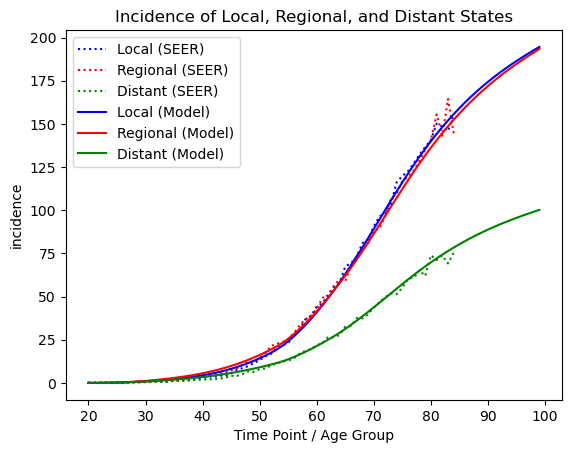

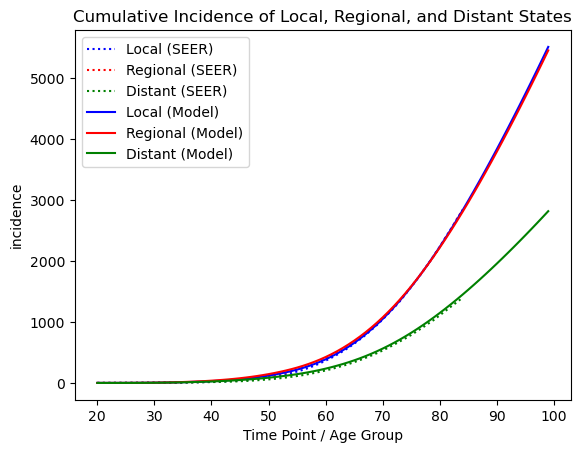

In [73]:
tmat5c = np.copy(tmat)
tmat5c[:,0,1] = np.maximum(tmat5c[:,0,1], func.probtoprob(0.003))  # Set lower bound for Norm to LR
tmat5c[:,1,2] = np.maximum(tmat5c[:,1,2], func.probtoprob(0.0075))  # Set lower bound for LR to HR
tmat5c[:,2,3] = np.maximum(tmat5c[:,2,3], func.probtoprob(0.04))  # Set lower bound for HR to uLoc
tmat5c[:,3,4] = np.minimum(tmat5c[:,3,4], func.probtoprob(0.4))  # Set upper bound for uLoc to uReg
tmat5c[:,4,5] = np.mean(tmat5c[:,4,5])  # Make constant
tmat5c[:,4,7] = np.minimum(tmat5c[:,4,7], func.probtoprob(0.7)) # Set upper bound for detecting Reg cancer
tmat5c[:,4,7] = np.maximum(tmat5c[:,4,7], func.probtoprob(0.55)) # Set lower bound for detecting Reg cancer
tmat5c = row_normalize(tmat5c)
log5c = m.run_markov_new(tmat5c)
plot_vs_seer(log5c, c.seer_inc)

In [33]:
func.probtoprob(0.035)

0.0029645285516241016

In [74]:
timestamp="20241029_1300"
out = np.zeros((8, 80))
for idx, (from_state, to_state) in enumerate(c.points):
    out[idx] = tmat5c[:, from_state, to_state]

pd.DataFrame(out).to_csv(f"../out/US/interp/tmats/{timestamp}_tps.csv")